## **Stackoverflow - Natural Language Processing**

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

**[1. Lecture des données](#lecture)**

**[2. Preprocessing](#EDA)**

  * [2.1. CreationDate](#CreationDate)
  * [2.2. Tags](#Tags)
  * [2.3. Title](#Title)
      * [2.3.1. Tokenization](#Tokens)
      * [2.3.2. Lemmatization](#Lemma)
  * [2.4. Body](#Body)

**[3. Analyse Exploratoire](#EDA)**

**[4. Approche Supervisée](#Supervisée)**
  * [4.1. Bag of Words](#bow)
  * [4.2. TF-IDF](#tfidf)
  * [4.3. Dimensinality Reduction](#reduction)
  * [4.4. Models](#models)

**[5. Approche Non-Supervisée](#NonSupervisée)**
  * [5.1. LDA Multicore with Gensim](#lda)

**[6. Hugging Face: Transformers](#NonSupervisée)**

**[7. Keras using Words Embeddings](#NonSupervisée)**

**[8. API Creation](#comparaison)**

 

# Data fetching

<h2> Recupération des données

Nous devons faire des requêtes SQL dans stack explorer pour récupérer des données utilisables. Pour le moment nous récupérons les données que pour un mois. Une fois que nous avons une version plus stable, nous augmenterons le nombre de données. 

SELECT TOP(100000) Id, CreationDate, Score, ViewCount, AnswerCount, CommentCount, FavoriteCount, Title, Body, Tags
FROM Posts
WHERE CreationDate BETWEEN CONVERT(datetime, '2020-01-01') AND CONVERT(datetime, '2020-07-01')
AND Score IS NOT NULL
AND ViewCount IS NOT NULL
AND AnswerCount IS NOT NULL
AND CommentCount IS NOT NULL
AND FavoriteCount IS NOT NULL
ORDER BY ViewCount DESC

<h2> Lecture des données
    <a name='lecture'>

In [2]:
from itertools import chain
from datetime import datetime
from stackoverflow_utils import *
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
import pandas as pd

2021-12-01 13:03:33.243619: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-01 13:03:33.243635: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
db = pd.read_csv('./Input_database/200k_QueryResults.csv')

In [4]:
db.head()

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,61339968,2020-04-21 09:16:35,147,387745,12,5,29,"Error message ""DevTools failed to load SourceM...",<p>I'm trying to display an image selected fro...,<javascript><html>
1,61205390,2020-04-14 10:19:16,78,323357,12,8,13,"When adding a JavaScript library, Chrome compl...","<h3>My code</h3>\n<pre class=""lang-html pretty...",<google-chrome-devtools>
2,59823283,2020-01-20 12:26:53,114,266124,15,0,47,Could not load dynamic library 'cudart64_101.d...,<p>I just installed the latest version of Tens...,<python><python-3.x><tensorflow><keras><tensor...
3,60296873,2020-02-19 09:24:42,109,253667,32,7,29,SessionNotCreatedException: Message: session n...,<p>I am currently new to robot framework.I am ...,<selenium><google-chrome><selenium-webdriver><...
4,60290309,2020-02-18 22:24:39,176,247270,30,3,18,error NG6002: Appears in the NgModule.imports ...,<p>First time using firestore and I'm getting ...,<angular><google-cloud-firestore><angularfire>


Dans un premier temps, pour des questions de simplicité, on va concentret sur les colonnes Tags et Titles uniquement

In [5]:
db.shape

(200000, 10)

In [6]:
n_sample = 50000
db = db.sample(n_sample,random_state=42)
db = db.reset_index(drop=True)

# Preprocessing

Par simplicité, faisons ces tranformations sur une seule de ces données. Nous scalerons ensuite ces transformations via une fonction

In [7]:
sample = db.iloc[0,:]
sample

Id                                                        54201469
CreationDate                                   2019-01-15 15:00:28
Score                                                           13
ViewCount                                                     3631
AnswerCount                                                      1
CommentCount                                                     2
FavoriteCount                                                    1
Title                         How to isolate Vuetify global styles
Body             <p>I've started to use Vue.js with Vuetify wit...
Tags                                     <css><vue.js><vuetify.js>
Name: 0, dtype: object

Les données nécessitant une transformation sont: Creation date, Title, Body, et Tags. 

## Preprocessing de la colonne Tags

In [8]:
type(sample['Tags'])

str

In [9]:
tag_list = db['Tags'].apply(lambda x: tags_cleaner(x))

In [10]:
tag_list

0                                [css, vue.js, vuetify.js]
1                                    [python, pyinstaller]
2        [amazon-web-services, amazon-ecs, serverless, ...
3                  [node.js, reactjs, deployment, restapi]
4        [javascript, node.js, payment-gateway, stripe-...
                               ...                        
49995                                [swift, swift4, moya]
49996                                     [vue.js, vuejs2]
49997    [javascript, angular, typescript, ionic-framew...
49998    [xcode, app-store-connect, ios-stickers, itune...
49999                                        [sql, presto]
Name: Tags, Length: 50000, dtype: object

In [11]:
db['Tags'] = tag_list
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,54201469,2019-01-15 15:00:28,13,3631,1,2,1,How to isolate Vuetify global styles,<p>I've started to use Vue.js with Vuetify wit...,"[css, vue.js, vuetify.js]"
1,63783524,2020-09-07 19:56:06,1,492,1,7,1,PyInstaller: UnicodeDecodeError: 'utf-8' codec...,<p>I was trying to convert my project to the e...,"[python, pyinstaller]"
2,57715829,2019-08-29 18:17:50,11,5542,3,3,1,Exposing to public more than 1 port with AWS E...,<p>I have service that exposes multiple ports ...,"[amazon-web-services, amazon-ecs, serverless, ..."
3,63552490,2020-08-23 22:09:19,1,793,1,0,1,Deploy ReactJs + MySQL + NodeJs Express project,<p>I'm newbie on ReactJs and NodeJs. Before us...,"[node.js, reactjs, deployment, restapi]"
4,61202493,2020-04-14 07:17:35,0,872,1,0,1,Change Currency code and amount according to u...,<pre><code>const session = stripe.checkout.ses...,"[javascript, node.js, payment-gateway, stripe-..."
...,...,...,...,...,...,...,...,...,...,...
49995,54936080,2019-02-28 23:57:37,7,3932,1,0,2,Refreshing auth token with Moya,"<p>I'm using <a href=""https://github.com/Moya/...","[swift, swift4, moya]"
49996,58265103,2019-10-07 07:23:16,1,2856,1,1,1,How to filter/search Element UI table with sep...,<p>I'm building a Element table in Vue (<a hre...,"[vue.js, vuejs2]"
49997,54047430,2019-01-04 23:16:03,7,1793,1,4,1,"In Angular 5, how to get access to dynamically...",<p>I am developing an Ionic + Angular 5 projec...,"[javascript, angular, typescript, ionic-framew..."
49998,56722921,2019-06-23 10:20:23,3,1168,1,0,1,How to fix ERROR ITMS-90680 StickerPackExtensi...,<p>Using <strong>XCode 10.2.1</strong></p>\n\n...,"[xcode, app-store-connect, ios-stickers, itune..."


In [12]:
tags_count = pd.Series(chain(*tag_list)).value_counts()
tags_top_500 = tags_count.nlargest(500)
tags_top_500

python              7049
javascript          4767
java                3132
reactjs             3045
android             2827
                    ... 
serialization         44
path                  44
paramiko              43
zsh                   43
google-cloud-run      43
Length: 500, dtype: int64

In [13]:
len(tags_count)

14017

In [14]:
tester = list(tags_top_500.keys())


Let's first clean the Tags column, by keeping the most common value only for each row

In [15]:
db['Tags'] = db['Tags'].apply(lambda x: most_common_selector(tags_top_500,x))
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,54201469,2019-01-15 15:00:28,13,3631,1,2,1,How to isolate Vuetify global styles,<p>I've started to use Vue.js with Vuetify wit...,"[css, vue.js, vuetify.js]"
1,63783524,2020-09-07 19:56:06,1,492,1,7,1,PyInstaller: UnicodeDecodeError: 'utf-8' codec...,<p>I was trying to convert my project to the e...,"[python, pyinstaller]"
2,57715829,2019-08-29 18:17:50,11,5542,3,3,1,Exposing to public more than 1 port with AWS E...,<p>I have service that exposes multiple ports ...,"[amazon-web-services, amazon-ecs]"
3,63552490,2020-08-23 22:09:19,1,793,1,0,1,Deploy ReactJs + MySQL + NodeJs Express project,<p>I'm newbie on ReactJs and NodeJs. Before us...,"[node.js, reactjs, deployment]"
4,61202493,2020-04-14 07:17:35,0,872,1,0,1,Change Currency code and amount according to u...,<pre><code>const session = stripe.checkout.ses...,"[javascript, node.js, stripe-payments]"
...,...,...,...,...,...,...,...,...,...,...
49995,54936080,2019-02-28 23:57:37,7,3932,1,0,2,Refreshing auth token with Moya,"<p>I'm using <a href=""https://github.com/Moya/...",[swift]
49996,58265103,2019-10-07 07:23:16,1,2856,1,1,1,How to filter/search Element UI table with sep...,<p>I'm building a Element table in Vue (<a hre...,"[vue.js, vuejs2]"
49997,54047430,2019-01-04 23:16:03,7,1793,1,4,1,"In Angular 5, how to get access to dynamically...",<p>I am developing an Ionic + Angular 5 projec...,"[javascript, angular, typescript, ionic-framew..."
49998,56722921,2019-06-23 10:20:23,3,1168,1,0,1,How to fix ERROR ITMS-90680 StickerPackExtensi...,<p>Using <strong>XCode 10.2.1</strong></p>\n\n...,[xcode]


Now, we would like to keep only the rows where the most common 200 tags are present

In [16]:
index_to_drop = []
for index, value in enumerate(db['Tags']):
    if len(value)==0:
        index_to_drop.append(index)       

In [17]:
len(index_to_drop)

2304

In [18]:
db.drop(index_to_drop, inplace=True)
db.reset_index(drop=True, inplace=True)

In [19]:
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,54201469,2019-01-15 15:00:28,13,3631,1,2,1,How to isolate Vuetify global styles,<p>I've started to use Vue.js with Vuetify wit...,"[css, vue.js, vuetify.js]"
1,63783524,2020-09-07 19:56:06,1,492,1,7,1,PyInstaller: UnicodeDecodeError: 'utf-8' codec...,<p>I was trying to convert my project to the e...,"[python, pyinstaller]"
2,57715829,2019-08-29 18:17:50,11,5542,3,3,1,Exposing to public more than 1 port with AWS E...,<p>I have service that exposes multiple ports ...,"[amazon-web-services, amazon-ecs]"
3,63552490,2020-08-23 22:09:19,1,793,1,0,1,Deploy ReactJs + MySQL + NodeJs Express project,<p>I'm newbie on ReactJs and NodeJs. Before us...,"[node.js, reactjs, deployment]"
4,61202493,2020-04-14 07:17:35,0,872,1,0,1,Change Currency code and amount according to u...,<pre><code>const session = stripe.checkout.ses...,"[javascript, node.js, stripe-payments]"
...,...,...,...,...,...,...,...,...,...,...
47691,54936080,2019-02-28 23:57:37,7,3932,1,0,2,Refreshing auth token with Moya,"<p>I'm using <a href=""https://github.com/Moya/...",[swift]
47692,58265103,2019-10-07 07:23:16,1,2856,1,1,1,How to filter/search Element UI table with sep...,<p>I'm building a Element table in Vue (<a hre...,"[vue.js, vuejs2]"
47693,54047430,2019-01-04 23:16:03,7,1793,1,4,1,"In Angular 5, how to get access to dynamically...",<p>I am developing an Ionic + Angular 5 projec...,"[javascript, angular, typescript, ionic-framew..."
47694,56722921,2019-06-23 10:20:23,3,1168,1,0,1,How to fix ERROR ITMS-90680 StickerPackExtensi...,<p>Using <strong>XCode 10.2.1</strong></p>\n\n...,[xcode]


## Preprocessing de la colonne Title

<h4> Tokenisation
         <a name="Tokens">

In [20]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import tensorflow as tf

[nltk_data] Downloading package stopwords to /home/efkant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
stop_words = set(stopwords.words('english'))

In [22]:
regularizer = lambda x : re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                   # The pattern to replace it with
                      x)

In [23]:
db['Title'] = db['Title'].apply(lambda x: regularizer(x))

In [24]:
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,54201469,2019-01-15 15:00:28,13,3631,1,2,1,How to isolate Vuetify global styles,<p>I've started to use Vue.js with Vuetify wit...,"[css, vue.js, vuetify.js]"
1,63783524,2020-09-07 19:56:06,1,492,1,7,1,PyInstaller UnicodeDecodeError utf codec...,<p>I was trying to convert my project to the e...,"[python, pyinstaller]"
2,57715829,2019-08-29 18:17:50,11,5542,3,3,1,Exposing to public more than port with AWS E...,<p>I have service that exposes multiple ports ...,"[amazon-web-services, amazon-ecs]"
3,63552490,2020-08-23 22:09:19,1,793,1,0,1,Deploy ReactJs MySQL NodeJs Express project,<p>I'm newbie on ReactJs and NodeJs. Before us...,"[node.js, reactjs, deployment]"
4,61202493,2020-04-14 07:17:35,0,872,1,0,1,Change Currency code and amount according to u...,<pre><code>const session = stripe.checkout.ses...,"[javascript, node.js, stripe-payments]"
...,...,...,...,...,...,...,...,...,...,...
47691,54936080,2019-02-28 23:57:37,7,3932,1,0,2,Refreshing auth token with Moya,"<p>I'm using <a href=""https://github.com/Moya/...",[swift]
47692,58265103,2019-10-07 07:23:16,1,2856,1,1,1,How to filter search Element UI table with sep...,<p>I'm building a Element table in Vue (<a hre...,"[vue.js, vuejs2]"
47693,54047430,2019-01-04 23:16:03,7,1793,1,4,1,In Angular how to get access to dynamically...,<p>I am developing an Ionic + Angular 5 projec...,"[javascript, angular, typescript, ionic-framew..."
47694,56722921,2019-06-23 10:20:23,3,1168,1,0,1,How to fix ERROR ITMS StickerPackExtensi...,<p>Using <strong>XCode 10.2.1</strong></p>\n\n...,[xcode]


In [25]:
# This tokenizer, makes tokens, put tokens in lower case and remove punctuations
db['Title'] = db['Title'].apply(lambda x: tokenizer(x))

In [26]:
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,54201469,2019-01-15 15:00:28,13,3631,1,2,1,"[how, to, isolate, vuetify, global, styles]",<p>I've started to use Vue.js with Vuetify wit...,"[css, vue.js, vuetify.js]"
1,63783524,2020-09-07 19:56:06,1,492,1,7,1,"[pyinstaller, unicodedecodeerror, utf, codec, ...",<p>I was trying to convert my project to the e...,"[python, pyinstaller]"
2,57715829,2019-08-29 18:17:50,11,5542,3,3,1,"[exposing, to, public, more, than, port, with,...",<p>I have service that exposes multiple ports ...,"[amazon-web-services, amazon-ecs]"
3,63552490,2020-08-23 22:09:19,1,793,1,0,1,"[deploy, reactjs, mysql, nodejs, express, proj...",<p>I'm newbie on ReactJs and NodeJs. Before us...,"[node.js, reactjs, deployment]"
4,61202493,2020-04-14 07:17:35,0,872,1,0,1,"[change, currency, code, and, amount, accordin...",<pre><code>const session = stripe.checkout.ses...,"[javascript, node.js, stripe-payments]"
...,...,...,...,...,...,...,...,...,...,...
47691,54936080,2019-02-28 23:57:37,7,3932,1,0,2,"[refreshing, auth, token, with, moya]","<p>I'm using <a href=""https://github.com/Moya/...",[swift]
47692,58265103,2019-10-07 07:23:16,1,2856,1,1,1,"[how, to, filter, search, element, ui, table, ...",<p>I'm building a Element table in Vue (<a hre...,"[vue.js, vuejs2]"
47693,54047430,2019-01-04 23:16:03,7,1793,1,4,1,"[in, angular, how, to, get, access, to, dynami...",<p>I am developing an Ionic + Angular 5 projec...,"[javascript, angular, typescript, ionic-framew..."
47694,56722921,2019-06-23 10:20:23,3,1168,1,0,1,"[how, to, fix, error, itms, stickerpackextensi...",<p>Using <strong>XCode 10.2.1</strong></p>\n\n...,[xcode]


In [27]:
db['Title'] = db['Title'].apply(lambda x:stop_words_check(x,stop_words))

In [28]:
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,54201469,2019-01-15 15:00:28,13,3631,1,2,1,"[isolate, vuetify, global, styles]",<p>I've started to use Vue.js with Vuetify wit...,"[css, vue.js, vuetify.js]"
1,63783524,2020-09-07 19:56:06,1,492,1,7,1,"[pyinstaller, unicodedecodeerror, utf, codec, ...",<p>I was trying to convert my project to the e...,"[python, pyinstaller]"
2,57715829,2019-08-29 18:17:50,11,5542,3,3,1,"[exposing, public, port, aws, ecs, service, el...",<p>I have service that exposes multiple ports ...,"[amazon-web-services, amazon-ecs]"
3,63552490,2020-08-23 22:09:19,1,793,1,0,1,"[deploy, reactjs, mysql, nodejs, express, proj...",<p>I'm newbie on ReactJs and NodeJs. Before us...,"[node.js, reactjs, deployment]"
4,61202493,2020-04-14 07:17:35,0,872,1,0,1,"[change, currency, code, amount, according, us...",<pre><code>const session = stripe.checkout.ses...,"[javascript, node.js, stripe-payments]"
...,...,...,...,...,...,...,...,...,...,...
47691,54936080,2019-02-28 23:57:37,7,3932,1,0,2,"[refreshing, auth, token, moya]","<p>I'm using <a href=""https://github.com/Moya/...",[swift]
47692,58265103,2019-10-07 07:23:16,1,2856,1,1,1,"[filter, search, element, table, separate, fun...",<p>I'm building a Element table in Vue (<a hre...,"[vue.js, vuejs2]"
47693,54047430,2019-01-04 23:16:03,7,1793,1,4,1,"[angular, get, access, dynamically, added, chi...",<p>I am developing an Ionic + Angular 5 projec...,"[javascript, angular, typescript, ionic-framew..."
47694,56722921,2019-06-23 10:20:23,3,1168,1,0,1,"[fix, error, itms, stickerpackextension, appex...",<p>Using <strong>XCode 10.2.1</strong></p>\n\n...,[xcode]


<h4> Lemmatization
         <a name="Lemma">


In [29]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /home/efkant/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [30]:
def list_lemmatizer(list_to_lem):
    return [lemmatizer.lemmatize(token, 'v') for token in list_to_lem]

In [31]:
db['Title'] = db['Title'].apply(lambda x: list_lemmatizer(x))

In [32]:
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,54201469,2019-01-15 15:00:28,13,3631,1,2,1,"[isolate, vuetify, global, style]",<p>I've started to use Vue.js with Vuetify wit...,"[css, vue.js, vuetify.js]"
1,63783524,2020-09-07 19:56:06,1,492,1,7,1,"[pyinstaller, unicodedecodeerror, utf, codec, ...",<p>I was trying to convert my project to the e...,"[python, pyinstaller]"
2,57715829,2019-08-29 18:17:50,11,5542,3,3,1,"[expose, public, port, aws, ecs, service, elas...",<p>I have service that exposes multiple ports ...,"[amazon-web-services, amazon-ecs]"
3,63552490,2020-08-23 22:09:19,1,793,1,0,1,"[deploy, reactjs, mysql, nodejs, express, proj...",<p>I'm newbie on ReactJs and NodeJs. Before us...,"[node.js, reactjs, deployment]"
4,61202493,2020-04-14 07:17:35,0,872,1,0,1,"[change, currency, code, amount, accord, user,...",<pre><code>const session = stripe.checkout.ses...,"[javascript, node.js, stripe-payments]"
...,...,...,...,...,...,...,...,...,...,...
47691,54936080,2019-02-28 23:57:37,7,3932,1,0,2,"[refresh, auth, token, moya]","<p>I'm using <a href=""https://github.com/Moya/...",[swift]
47692,58265103,2019-10-07 07:23:16,1,2856,1,1,1,"[filter, search, element, table, separate, fun...",<p>I'm building a Element table in Vue (<a hre...,"[vue.js, vuejs2]"
47693,54047430,2019-01-04 23:16:03,7,1793,1,4,1,"[angular, get, access, dynamically, add, child...",<p>I am developing an Ionic + Angular 5 projec...,"[javascript, angular, typescript, ionic-framew..."
47694,56722921,2019-06-23 10:20:23,3,1168,1,0,1,"[fix, error, itms, stickerpackextension, appex...",<p>Using <strong>XCode 10.2.1</strong></p>\n\n...,[xcode]


In [33]:
db['Title'] = db['Title'].apply(lambda x: " ".join(x))

In [34]:
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags
0,54201469,2019-01-15 15:00:28,13,3631,1,2,1,isolate vuetify global style,<p>I've started to use Vue.js with Vuetify wit...,"[css, vue.js, vuetify.js]"
1,63783524,2020-09-07 19:56:06,1,492,1,7,1,pyinstaller unicodedecodeerror utf codec decod...,<p>I was trying to convert my project to the e...,"[python, pyinstaller]"
2,57715829,2019-08-29 18:17:50,11,5542,3,3,1,expose public port aws ecs service elastic loa...,<p>I have service that exposes multiple ports ...,"[amazon-web-services, amazon-ecs]"
3,63552490,2020-08-23 22:09:19,1,793,1,0,1,deploy reactjs mysql nodejs express project,<p>I'm newbie on ReactJs and NodeJs. Before us...,"[node.js, reactjs, deployment]"
4,61202493,2020-04-14 07:17:35,0,872,1,0,1,change currency code amount accord user countr...,<pre><code>const session = stripe.checkout.ses...,"[javascript, node.js, stripe-payments]"
...,...,...,...,...,...,...,...,...,...,...
47691,54936080,2019-02-28 23:57:37,7,3932,1,0,2,refresh auth token moya,"<p>I'm using <a href=""https://github.com/Moya/...",[swift]
47692,58265103,2019-10-07 07:23:16,1,2856,1,1,1,filter search element table separate function,<p>I'm building a Element table in Vue (<a hre...,"[vue.js, vuejs2]"
47693,54047430,2019-01-04 23:16:03,7,1793,1,4,1,angular get access dynamically add child compo...,<p>I am developing an Ionic + Angular 5 projec...,"[javascript, angular, typescript, ionic-framew..."
47694,56722921,2019-06-23 10:20:23,3,1168,1,0,1,fix error itms stickerpackextension appex cont...,<p>Using <strong>XCode 10.2.1</strong></p>\n\n...,[xcode]


## Preprocessing de la Colonne Body

In [35]:
from bs4 import BeautifulSoup

In [36]:
db['Body'] = db['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [37]:
db['Body'] = db['Body'].apply(lambda x: clean_text(x)) 

In [38]:
db['Body'][14]

'i am working on an app using the mvvm pattern with rxjava. the architecture is the following: it the first time i use this pattern and i am not sure about the best way to update a viewmodel (and consequently the corresponding view) when a change occurs in the data, made by another component of the application. for example: suppose we have an activity showing the list of users i follow (like a social app), from this list i select a user and open his profile in another activity. now, from this second activity i decide to unfollow the user and when i press the back button to return to the first activity i would like the list to be updated automatically (deleting the corresponding user, obviously without having to re-download all the data). the problem is that the two activity have two different viewmodel. how can i make the changes made by the second activity affect the viewmodel of the first one? is it the responsibility of the repository to inform the first activity of the changes? i w

In [39]:
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'

In [40]:
db['Body'] = db['Body'].apply(lambda x: clean_punct(x,tags_top_500))

Now we have to remove the stopwords, tokenize and lemmatize the Body column

In [41]:
db['Body'] = db['Body'].apply(lambda x: tokenizer(x))

In [42]:
db['Body'] = db['Body'].apply(lambda x: stop_words_check(x,stop_words))

In [43]:
db['Body'] = db['Body'].apply(lambda x: list_lemmatizer(x))

In [44]:
db['Body'] = db['Body'].apply(lambda x: " ".join(x))

In [45]:
#Ici, on a met plus de poids sur les titres en mettant Title plusieurs fois dans la nouvelle colonne que l'on créer
db['Post'] = db['Title']+" "+db['Body']+" "+db['Title']+" "+db['Title']+" "+db['Title']

In [46]:
db

,Id,CreationDate,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,Title,Body,Tags,Post
0,54201469,2019-01-15 15:00:28,13,3631,1,2,1,isolate vuetify global style,start use vue vuetify within old exist project...,"[css, vue.js, vuetify.js]",isolate vuetify global style start use vue vue...
1,63783524,2020-09-07 19:56:06,1,492,1,7,1,pyinstaller unicodedecodeerror utf codec decod...,try convert project exe pyinstaller try soluti...,"[python, pyinstaller]",pyinstaller unicodedecodeerror utf codec decod...
2,57715829,2019-08-29 18:17:50,11,5542,3,3,1,expose public port aws ecs service elastic loa...,service expose multiple port work fine kuberne...,"[amazon-web-services, amazon-ecs]",expose public port aws ecs service elastic loa...
3,63552490,2020-08-23 22:09:19,1,793,1,0,1,deploy reactjs mysql nodejs express project,newbie reactjs nodejs use php program language...,"[node.js, reactjs, deployment]",deploy reactjs mysql nodejs express project ne...
4,61202493,2020-04-14 07:17:35,0,872,1,0,1,change currency code amount accord user countr...,const session stripe checkout sessions create ...,"[javascript, node.js, stripe-payments]",change currency code amount accord user countr...
...,...,...,...,...,...,...,...,...,...,...,...
47691,54936080,2019-02-28 23:57:37,7,3932,1,0,2,refresh auth token moya,use moya communicate api many endpoints requir...,[swift],refresh auth token moya use moya communicate a...
47692,58265103,2019-10-07 07:23:16,1,2856,1,1,1,filter search element table separate function,build element table vue https element eleme co...,"[vue.js, vuejs2]",filter search element table separate function ...
47693,54047430,2019-01-04 23:16:03,7,1793,1,4,1,angular get access dynamically add child compo...,develop ionic angular project need dynamically...,"[javascript, angular, typescript, ionic-framew...",angular get access dynamically add child compo...
47694,56722921,2019-06-23 10:20:23,3,1168,1,0,1,fix error itms stickerpackextension appex cont...,use xcode submit first stickers app ios test u...,[xcode],fix error itms stickerpackextension appex cont...


# EDA

<h4> Exploration des variables génériques

In [47]:
import seaborn as sns

In [48]:
db.describe()

,Id,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount
count,4.769600e+04,47696.000000,47696.000000,47696.000000,47696.000000,47696.000000
mean,5.958668e+07,4.310990,3602.070048,1.793693,2.155003,1.501803
std,3.316014e+06,10.561401,9887.329994,1.585075,2.954223,2.575921
min,5.399295e+07,-24.000000,124.000000,0.000000,0.000000,0.000000
25%,5.682806e+07,1.000000,685.000000,1.000000,0.000000,1.000000
50%,5.949391e+07,2.000000,1457.500000,1.000000,1.000000,1.000000
75%,6.261780e+07,5.000000,3297.000000,2.000000,3.000000,2.000000
max,6.551476e+07,693.000000,679582.000000,39.000000,46.000000,195.000000


In [49]:
fig = px.bar(tags_top_500.nlargest(40))
fig.show()

(0.0, 50000.0)

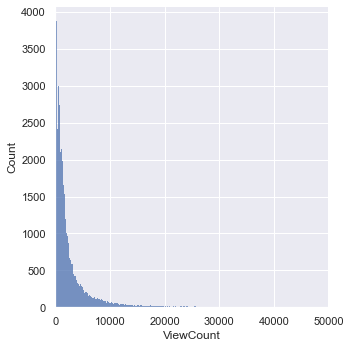

In [50]:
sns.set_theme()
ax = sns.displot(db['ViewCount'])
plt.xlim(0,50000)


(0.0, 40.0)

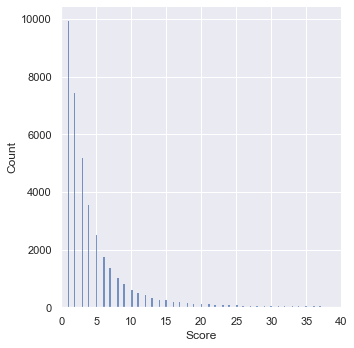

In [51]:
sns.set_theme()
ax = sns.displot(db['Score'])
plt.xlim(0,40)

(0.0, 20.0)

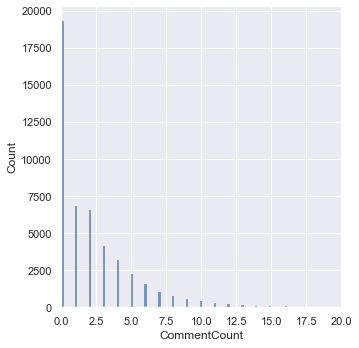

In [52]:
sns.set_theme()
ax = sns.displot(db['CommentCount'])
plt.xlim(0,20)

# Supervised Learning

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer

In [54]:
X = np.array(db['Post'])
y = np.array(db['Tags'])

In [55]:
y.shape

(47696,)

In [56]:
mlb = MultiLabelBinarizer()

In [57]:
mlb.fit(y)
y_encoded = mlb.transform(y)

In [58]:
y_encoded.shape

(47696, 500)

<h4>Utilisation de Bag of Words

<a name='bow'>

In [59]:
vectorizer_X_BoW = CountVectorizer()


X_bow = vectorizer_X_BoW.fit_transform(X)

In [60]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, y_encoded, test_size = 0.20, random_state = 0) # Do 80/20 split

<h4> Utilisation de TF-IDF
    <a name='tfidf'>

In [61]:
vectorizer_X = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=30000)

In [62]:
X_tfidf = vectorizer_X.fit_transform(X)

In [63]:
X_tfidf.shape

(47696, 30000)

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size = 0.20, random_state = 0) # Do 80/20 split

In [65]:
X_train.shape

(38156, 30000)

<h4> Dimensionality reduction
    <a name='reduction'>

In [66]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.pyplot as plt

In [67]:
svd = TruncatedSVD(n_components=2500)
svd.fit(X_train)
#display_scree_plot(svd)

TruncatedSVD(n_components=2500)

In [68]:
X_train_svd = svd.transform(X_train)
X_test_svd = svd.transform(X_test)

<h4> Models 
    <a name = 'models'>

In [69]:
from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, jaccard_score, make_scorer
from sklearn.neural_network import MLPClassifier

In [70]:
models_performance = {}

<h4> MultiOutputClassifier approach

In [71]:
dummy = DummyClassifier()
svc = SGDClassifier(n_jobs=-1) #Hinge Loss / Reg = L2
lin_svc = LinearSVC()
lr = LogisticRegression(solver="liblinear")

metrics_results = pd.DataFrame(index=["Accuracy", "F1","Jaccard", "Recall","Precision"])

for classifier in [dummy,lr,lin_svc,svc]:
    clf = MultiOutputClassifier(classifier,n_jobs=-1)
    clf.fit(X_train_svd, y_train)
    y_pred = clf.predict(X_test_svd)
    metrics_score(classifier.__class__.__name__,df=metrics_results,y_true=y_test,y_pred = y_pred)
metrics_results

/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/sklearn/utils/deprecation.py:103: FutureWarning:

`n_features_in_` is deprecated in 1.0 and will be removed in 1.2.

/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior

,DummyClassifier,LogisticRegression,LinearSVC,SGDClassifier
Accuracy,0.0,0.138260,0.209015,0.163732
F1,0.0,0.591588,0.670009,0.675427
Jaccard,0.0,0.314760,0.434074,0.338838
Recall,0.0,0.340187,0.483031,0.366759
Precision,0.0,0.696379,0.727796,0.654149


In [72]:
opt_clf = MultiOutputClassifier(svc,n_jobs=-1)

In [73]:
opt_clf.get_params()

{'estimator__alpha': 0.0001,
 'estimator__average': False,
 'estimator__class_weight': None,
 'estimator__early_stopping': False,
 'estimator__epsilon': 0.1,
 'estimator__eta0': 0.0,
 'estimator__fit_intercept': True,
 'estimator__l1_ratio': 0.15,
 'estimator__learning_rate': 'optimal',
 'estimator__loss': 'hinge',
 'estimator__max_iter': 1000,
 'estimator__n_iter_no_change': 5,
 'estimator__n_jobs': -1,
 'estimator__penalty': 'l2',
 'estimator__power_t': 0.5,
 'estimator__random_state': None,
 'estimator__shuffle': True,
 'estimator__tol': 0.001,
 'estimator__validation_fraction': 0.1,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': SGDClassifier(n_jobs=-1),
 'n_jobs': -1}

In [74]:
params = {
    'estimator__alpha':[1e-4, 1e-3 ,1e-2, 1e-1],
    'estimator__l1_ratio':[0,0.1,0.2,0.5,0.8],
    'estimator__learning_rate': ['optimal'],
}

In [75]:
grid_opt_clf = GridSearchCV(opt_clf,
                              param_grid=params,
                              n_jobs=-1,
                              scoring=make_scorer(scorer_jaccard),
                              verbose=False,
                              cv=2,
                              refit=True
                             )
grid_opt_clf.fit(X_train_svd, y_train)

2021-12-01 13:34:36.533405: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-01 13:34:36.533404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-01 13:34:36.533406: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-01 13:34:36.533404: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-01 13:34:36.533405: W tensorflow/stream_executor/platform/default/dso_lo

GridSearchCV(cv=2,
             estimator=MultiOutputClassifier(estimator=SGDClassifier(n_jobs=-1),
                                             n_jobs=-1),
             n_jobs=-1,
             param_grid={'estimator__alpha': [0.0001, 0.001, 0.01, 0.1],
                         'estimator__l1_ratio': [0, 0.1, 0.2, 0.5, 0.8],
                         'estimator__learning_rate': ['optimal']},
             scoring=make_scorer(scorer_jaccard), verbose=False)

In [76]:
grid_opt_clf.best_params_, grid_opt_clf.best_score_

({'estimator__alpha': 0.0001,
  'estimator__l1_ratio': 0.8,
  'estimator__learning_rate': 'optimal'},
 0.3481315750385378)

In [77]:
y_pred = grid_opt_clf.predict(X_test_svd)
metrics_score('Grid_opt_clf',df=metrics_results,y_true=y_test,y_pred = y_pred)
metrics_score

/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



<function stackoverflow_utils.metrics_score(model, df, y_true, y_pred)>

In [78]:
metrics_results

,DummyClassifier,LogisticRegression,LinearSVC,SGDClassifier,Grid_opt_clf
Accuracy,0.0,0.138260,0.209015,0.163732,0.162264
F1,0.0,0.591588,0.670009,0.675427,0.677179
Jaccard,0.0,0.314760,0.434074,0.338838,0.336734
Recall,0.0,0.340187,0.483031,0.366759,0.363957
Precision,0.0,0.696379,0.727796,0.654149,0.653717


In [79]:
y_pred_supervised = mlb.inverse_transform(y_pred)

In [80]:
y_test_labels = mlb.inverse_transform(y_test)

In [81]:
test_labels = pd.Series(y_test_labels)
y_pred_supervised = pd.Series(y_pred_supervised)

Results = pd.concat([test_labels, y_pred_supervised], axis=1) 
Results.rename(columns={0 : 'Test labels', 1 : 'Supervised predicted labels'}, inplace=True)
Results

,Test labels,Supervised predicted labels
0,"(ios, iphone, objective-c, xcode)",()
1,"(dart, homebrew)","(dart, flutter)"
2,"(c#, unity3d)",()
3,"(java, jenkins, selenium)","(selenium,)"
4,"(apache, docker, kubernetes)","(kubernetes,)"
...,...,...
9535,"(asp.net-core, asp.net-core-3.1, asp.net-core-...","(asp.net-core, c#)"
9536,"(amazon-web-services, plotly-dash, python)","(plotly-dash, python)"
9537,"(powerbi,)",()
9538,"(c++, c++17)",()


# Unsupervised Learning

<h4> LDA Multicore using Gensim
    <a name="lda">

In [82]:
import gensim
from gensim.models import TfidfModel
import gensim.corpora as corpora
from gensim import models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel
import math

2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50


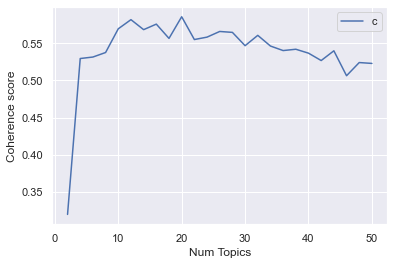

In [83]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Args:
  
        dictionary : Gensim dictionary
        corpus : Gensim corpus
        texts : List of input texts
        limit : Max num of topics

    Returns:
    
        model_list : List of LDA topic models
        coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    
    
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = LdaMulticore(corpus=corpus,
                            id2word=dictionary,
                            num_topics=num_topics, 
                            random_state=42,
                            passes=10,
                            workers=7)

        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

texts = db['Post'].apply(lambda x : x.split(' '))
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=1000)
bow_corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = [tfidf[text] for text in bow_corpus]

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=tfidf_corpus, texts=texts, start=2, limit=51, step=2)


limit=51; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [84]:
texts = db['Post'].apply(lambda x : x.split(' '))
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=100)
bow_corpus = [id2word.doc2bow(text) for text in texts]

In [85]:
model = LdaMulticore(corpus=bow_corpus,
                            id2word=id2word,
                            num_topics=20, 
                            random_state=42,
                            passes=10,
                            workers=5)

In [86]:
coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
coherencemodel.get_coherence()

0.5560281278017414

In [87]:
perplexity = model.log_perplexity(bow_corpus)
math.pow(2,perplexity)

0.011554964307869607

In [88]:
model.print_topics()

[(0,
  '0.065*"self" + 0.055*"model" + 0.022*"train" + 0.020*"tensorflow" + 0.019*"input" + 0.018*"layer" + 0.017*"def" + 0.015*"keras" + 0.013*"import" + 0.012*"batch"'),
 (1,
  '0.125*"file" + 0.021*"path" + 0.016*"read" + 0.013*"upload" + 0.013*"json" + 0.011*"name" + 0.011*"folder" + 0.011*"get" + 0.011*"data" + 0.011*"download"'),
 (2,
  '0.146*"java" + 0.039*"org" + 0.035*"com" + 0.032*"apache" + 0.030*"android" + 0.026*"spark" + 0.017*"lang" + 0.015*"scala" + 0.013*"util" + 0.012*"class"'),
 (3,
  '0.054*"string" + 0.036*"public" + 0.033*"class" + 0.031*"type" + 0.025*"return" + 0.023*"name" + 0.020*"object" + 0.020*"new" + 0.019*"null" + 0.019*"value"'),
 (4,
  '0.041*"div" + 0.030*"class" + 0.023*"button" + 0.021*"form" + 0.016*"text" + 0.013*"input" + 0.013*"style" + 0.012*"value" + 0.012*"click" + 0.011*"html"'),
 (5,
  '0.047*"image" + 0.015*"color" + 0.015*"var" + 0.013*"data" + 0.012*"plot" + 0.011*"swiftui" + 0.010*"let" + 0.010*"product" + 0.010*"text" + 0.009*"point"')

In [89]:
import pyLDAvis.gensim_models

In [90]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, bow_corpus, id2word)
vis

/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/efkant/anaconda3/envs/stack_tags/lib/py

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9      0.169114 -0.088344       1        1  7.544888
3      0.077442  0.011244       2        1  7.373318
6     -0.019815 -0.013732       3        1  7.003165
18     0.041068 -0.087798       4        1  6.973651
8     -0.096019 -0.099256       5        1  6.764437
4      0.199277  0.132084       6        1  6.531218
11    -0.130738 -0.137776       7        1  6.032640
7     -0.002431 -0.032642       8        1  5.996182
10    -0.005724 -0.105047       9        1  5.510881
16     0.138388 -0.069945      10        1  4.933341
5      0.204863  0.019726      11        1  4.805867
1      0.018470 -0.126876      12        1  4.495630
0      0.082786 -0.067121      13        1  3.848894
17    -0.030283  0.036789      14        1  3.843282
14    -0.099023 -0.063087      15        1  3.771584
2     -0.261325  0.141333      16        1  3.425528
12     0.129387  0.278438      17        1  3.407766
19    -0.268375  0.083927      18        1  2.953864
13     0.113362  0.116849      19        1  2.575770
15    -0.260424  0.071234      20        1  2.208093, topic_info=        Term          Freq         Total Category  logprob  loglift
443     java  44031.000000  44031.000000  Default  30.0000  30.0000
19      file  60796.000000  60796.000000  Default  29.0000  29.0000
556  android  33819.000000  33819.000000  Default  28.0000  28.0000
256      org  28011.000000  28011.000000  Default  27.0000  27.0000
263     test  28539.000000  28539.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
410     core   1864.966847  16789.495724  Topic20  -4.4101   1.6155
169      api   1486.314936  21215.500554  Topic20  -4.6371   1.1546
44   project   1302.777973  16993.354776  Topic20  -4.7689   1.2447
602     fail   1106.493779  14856.590032  Topic20  -4.9322   1.2158
163  service    927.285592  16131.512738  Topic20  -5.1089   0.9568

[1308 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1352      1  0.925242         'a'
1352      2  0.006697         'a'
1352      3  0.001116         'a'
1352      6  0.013393         'a'
1352      8  0.001116         'a'
...     ...       ...         ...
2222     10  0.016129        zoom
2222     11  0.954291        zoom
2222     13  0.008064        zoom
2222     14  0.009409        zoom
2895     16  0.997505  zygoteinit

[9761 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 7, 19, 9, 5, 12, 8, 11, 17, 6, 2, 1, 18, 15, 3, 13, 20, 14, 16])

In [91]:
# Calculate Document/topic matrix with Gensim
doc_topic = pd.DataFrame(model\
                             .get_document_topics(bow_corpus,
                                                  minimum_probability=0))
for topic in doc_topic.columns:
    doc_topic[topic] = doc_topic[topic].apply(lambda x : x[1])

print('document/tag : ', y_encoded.shape)
print('document/topic : ', doc_topic.shape)

document/tag :  (47696, 500)
document/topic :  (47696, 20)


In [92]:
doc_topic

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000417,0.000417,0.000417,0.000417,0.375520,0.000417,0.535145,0.000417,0.000417,0.000417,0.082249,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417,0.000417
1,0.000104,0.126960,0.000104,0.000104,0.000104,0.000104,0.000104,0.000104,0.000104,0.000104,0.000104,0.844147,0.000104,0.000104,0.000104,0.000104,0.027121,0.000104,0.000104,0.000104
2,0.000658,0.000658,0.000658,0.063846,0.037058,0.000658,0.000658,0.000658,0.706692,0.000658,0.000658,0.000658,0.000658,0.000658,0.000658,0.000658,0.000658,0.000658,0.181877,0.000658
3,0.000676,0.015316,0.000676,0.000676,0.000676,0.000676,0.365530,0.000676,0.249225,0.000676,0.106433,0.000676,0.000676,0.000676,0.039541,0.000676,0.000676,0.000676,0.214493,0.000676
4,0.000481,0.000481,0.000481,0.000481,0.029919,0.439778,0.000481,0.157752,0.000481,0.000481,0.000481,0.000481,0.000481,0.000481,0.000481,0.000481,0.000481,0.000481,0.364857,0.000481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47691,0.033513,0.000208,0.000208,0.240262,0.000208,0.000208,0.000208,0.295261,0.000208,0.000208,0.000208,0.000208,0.000208,0.000208,0.032285,0.000208,0.000208,0.000208,0.395554,0.000208
47692,0.000667,0.000667,0.000667,0.000667,0.388316,0.000667,0.000667,0.000667,0.000667,0.599682,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667,0.000667
47693,0.000329,0.000329,0.000329,0.000329,0.000329,0.000329,0.422239,0.000329,0.000329,0.044756,0.000329,0.000329,0.148405,0.060693,0.000329,0.000329,0.000329,0.000329,0.318972,0.000329
47694,0.000538,0.507781,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.000538,0.033827,0.000538,0.000538,0.000538,0.000538,0.100299,0.000538,0.349489,0.000538,0.000538


In [93]:
topic_tag = np.matmul(doc_topic.T,y_encoded)

In [94]:
y_results = pd.DataFrame(y)
y_results["best_topic"] = doc_topic.idxmax(axis=1).values
y_results["nb_tags"] = y_results[0].apply(lambda x : len(x))

df_y_bin = pd.DataFrame(y_encoded)
df_dict = dict(
    list(
        df_y_bin.groupby(df_y_bin.index)
    )
)

tags_num = []
for k, v in df_dict.items():
    check = v.columns[(v == 1).any()]
    tags_num.append(check.to_list())

y_results["y_true"] = tags_num
y_results

,0,best_topic,nb_tags,y_true
0,"[css, vue.js, vuetify.js]",6,3,"[111, 474, 476]"
1,"[python, pyinstaller]",11,2,"[357, 362]"
2,"[amazon-web-services, amazon-ecs]",8,2,"[10, 13]"
3,"[node.js, reactjs, deployment]",6,3,"[127, 310, 383]"
4,"[javascript, node.js, stripe-payments]",5,3,"[247, 310, 433]"
...,...,...,...,...
47691,[swift],18,1,[438]
47692,"[vue.js, vuejs2]",9,2,"[474, 475]"
47693,"[javascript, angular, typescript, ionic-framew...",6,4,"[27, 235, 247, 457]"
47694,[xcode],1,1,[494]


In [95]:
list_tag = []
for row in y_results.itertuples():
    nb_tags = row.nb_tags
    best_topic = row.best_topic
    row_tags = list(topic_tag.iloc[best_topic]\
                    .sort_values(ascending=False)[0:nb_tags].index)
    list_tag.append(row_tags)
    
y_results["y_pred"] = list_tag
y_results

,0,best_topic,nb_tags,y_true,y_pred
0,"[css, vue.js, vuetify.js]",6,3,"[111, 474, 476]","[383, 247, 27]"
1,"[python, pyinstaller]",11,2,"[357, 362]","[362, 365]"
2,"[amazon-web-services, amazon-ecs]",8,2,"[10, 13]","[137, 264]"
3,"[node.js, reactjs, deployment]",6,3,"[127, 310, 383]","[383, 247, 27]"
4,"[javascript, node.js, stripe-payments]",5,3,"[247, 310, 433]","[362, 438, 440]"
...,...,...,...,...,...
47691,[swift],18,1,[438],[13]
47692,"[vue.js, vuejs2]",9,2,"[474, 475]","[362, 330]"
47693,"[javascript, angular, typescript, ionic-framew...",6,4,"[27, 235, 247, 457]","[383, 247, 27, 310]"
47694,[xcode],1,1,[494],[362]


In [96]:
# Create matrix for pred and true y LDA
lda_y_pred = np.zeros(y_encoded.shape)
n = 0
for row in y_results.y_pred.values:
    for i in range(len(row)):
        lda_y_pred[n,row[i]] = 1
    n+=1
    
lda_y_true = np.zeros(y_encoded.shape)
m = 0
for row in y_results.y_true.values:
    for i in range(len(row)):
        lda_y_true[m,row[i]] = 1
    m+=1

In [97]:
df_metrics_compare = metrics_score("LDA", df=metrics_results,
                                   y_true=lda_y_true,
                                   y_pred=lda_y_pred)
df_metrics_compare

/home/efkant/anaconda3/envs/stack_tags/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



,DummyClassifier,LogisticRegression,LinearSVC,SGDClassifier,Grid_opt_clf,LDA
Accuracy,0.0,0.138260,0.209015,0.163732,0.162264,0.067867
F1,0.0,0.591588,0.670009,0.675427,0.677179,0.331939
Jaccard,0.0,0.314760,0.434074,0.338838,0.336734,0.096840
Recall,0.0,0.340187,0.483031,0.366759,0.363957,0.244765
Precision,0.0,0.696379,0.727796,0.654149,0.653717,0.135055
